In [1]:
!pip install auto-esn==0.0.7

You should consider upgrading via the '/Users/marcinwasowicz/AGH/agh_env/bin/python3.9 -m pip install --upgrade pip' command.


Make sure you click **"restart runtime"** above. You may get an " cannot import name '_png' from 'matplotlib'" error otherwise later in the lab


In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import auto_esn.utils.dataset_loader as dl
from auto_esn.datasets.df import MackeyGlass
from auto_esn.esn.esn import GroupedDeepESN, DeepESN
from auto_esn.esn.reservoir.util import NRMSELoss
from auto_esn.esn.reservoir.activation import tanh

/Users/marcinwasowicz/AGH/agh_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The easiest way to use the lib for typical 1-dim time series prediction

If you have a time series in .csv format, just make sure the values are under y column and use builtin loader
In this example you'll end up with 600 train and 400 test samples.
Leave max_samples empty and you'll get the whole series
you can pass either path or pd.Dataframe with 'y' column
code presented here can be found here: https://github.com/Ro6ertWcislo/AutoESN/blob/master/src/auto_esn/examples/easiest_example_mg.py 

and the dataset here:

https://github.com/Ro6ertWcislo/AutoESN/blob/master/src/auto_esn/datasets/mg10.csv

### To browse other examples click [here](https://github.com/Ro6ertWcislo/AutoESN/tree/b3d2e287716176fc3e1312b5be2a7a0b91ba538e/src/auto_esn/examples)

In [3]:
mg17 = dl.loader_explicit(MackeyGlass, test_size=400)
# use it to load 1000 samples - 600 for train, 400 for test and devide dispatch it into torch.tensors:
X, X_test, y, y_test = mg17()

In [4]:
print(X.size())
print(X_test.size())
print(y.size())
print(y_test.size())

torch.Size([799, 1])
torch.Size([400, 1])
torch.Size([799, 1])
torch.Size([400, 1])


In [5]:
# initialize shallow 1-layer ESN with deafult settings
esn = DeepESN(num_layers=1)

In [6]:
# train. In this example we feed tesors with size [600, 1] to the esn.
esn.fit(X, y)

In [7]:
# predict
output = esn(X_test)
output.size()

torch.Size([400, 1])

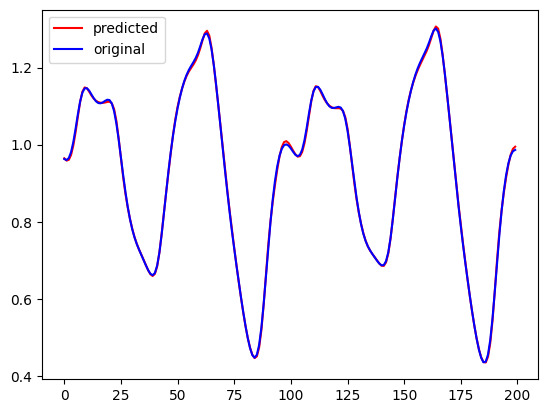

In [8]:
# visualize
last = 200
plt.plot(range(last), output.view(-1).detach().numpy()[-last:], "r", label="predicted")
plt.plot(range(last), y_test.view(-1).detach().numpy()[-last:], "b", label="original")
plt.legend()
plt.show()

### Let's now see at multidimenstional input

Let's reuse the data we had and create a new series out of it

In [9]:
print(f"Size of X: {X.shape}, X_test: {X_test.shape}")
# double the dimensionality of test and train input
X2 = torch.cat((X, X), dim=1)
X_test2 = torch.cat((X_test, X_test), dim=1)
print(f"Size of doubled X: {X2.shape}, X_test: {X_test2.shape}")

Size of X: torch.Size([799, 1]), X_test: torch.Size([400, 1])
Size of doubled X: torch.Size([799, 2]), X_test: torch.Size([400, 2])


 For the sake of next-step prediction you will usually use just one, potentially multidimensional time series - this is reflected in the shapes of tensor, doubled X size is [600, 2], whichrepresents 1 time series of 2-dimensional data (1st dim) with 600 time steps (0th dim). 

The rest works the same as in previous example:

In [10]:
# now choose activation function and configure it:
activation = tanh(leaky_rate=0.9)
# go with 2 layers with chosen layer size:

esn = DeepESN(
    input_size=2,  # !!!! this part is important. You need to set it to the dimensionality of your input (1st dim in the tensor)
    num_layers=1,
    hidden_size=100,
    activation=activation,
)

In [11]:
esn.fit(X2, y)
# predict
output = esn(X_test2)
output.size()  # look - a 1 dimensional output. One can produce multidimensional output and we will see it in next example.

torch.Size([400, 1])

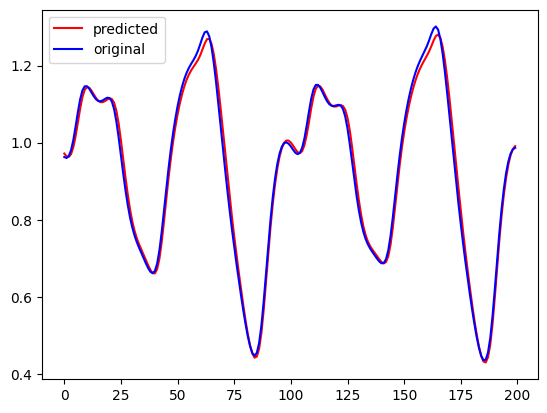

In [12]:
last = 200
plt.plot(range(last), output.view(-1).detach().numpy()[-last:], "r", label="predicted")
plt.plot(range(last), y_test.view(-1).detach().numpy()[-last:], "b", label="original")
plt.legend()
plt.show()

# Now let's prepare a multidimensional output too

In [13]:
print(
    f"Size of X: {X.shape}, X_test: {X_test.shape}, y: {y.shape}, y_test: {y_test.shape}"
)
# double the dimensionality of test and train input
# second series is shifted by 1
X2 = torch.cat((X, X - 1), dim=1)
y2 = torch.cat((y, y - 1), dim=1)
# double the dimensionality of test and train output
# second series is shifted by 1
X_test2 = torch.cat((X_test, X_test - 1), dim=1)
y_test2 = torch.cat((y_test, y_test - 1), dim=1)
print(
    f"Size of doubled X: {X2.shape}, X_test: {X_test2.shape}, y: {y2.shape}, y_test: {y_test2.shape}"
)

Size of X: torch.Size([799, 1]), X_test: torch.Size([400, 1]), y: torch.Size([799, 1]), y_test: torch.Size([400, 1])
Size of doubled X: torch.Size([799, 2]), X_test: torch.Size([400, 2]), y: torch.Size([799, 2]), y_test: torch.Size([400, 2])


In [14]:
# let's take the same model, as previously
esn = DeepESN(
    input_size=2,  # !!!! this part is important. You need to set it to the dimensionality of your input (1st dim in the tensor)
    num_layers=2,
    hidden_size=100,
    activation=activation,
)

In [15]:
esn.fit(X2, y2)
# predict
output = esn(X_test2)
output.size()  # look - now we got a 2-dimensional output, as y also was 2dimensional

torch.Size([400, 2])

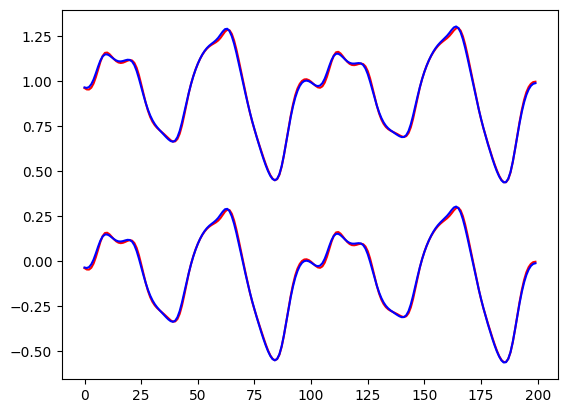

In [16]:
# we have 2dimensional input, so we have to plot two series for ground truth and for prediction
# plot original prediction
plt.plot(range(last), output[:, 0].view(-1).detach().numpy()[-last:], "r")
# plot shifted prediction
plt.plot(range(last), output[:, 1].view(-1).detach().numpy()[-last:], "r")
# plot original ground truth
plt.plot(range(last), y_test2[:, 0].view(-1).detach().numpy()[-last:], "b")
# plot shifted ground truth
plt.plot(range(last), y_test2[:, 1].view(-1).detach().numpy()[-last:], "b")
plt.show()

# Last example will be about extrapolation

In [37]:
# Initialize dataset and create ESN like before.
extrapolation_steps = 100

mg17 = dl.loader_explicit(MackeyGlass, test_size=extrapolation_steps)
X, X_test, y, y_test = mg17()
print(X.size())
print(X_test.size())
print(y.size())
print(y_test.size())


esn = DeepESN(num_layers=2, hidden_size=500)

# fit
esn.fit(X, y)
print(X)

torch.Size([1099, 1])
torch.Size([100, 1])
torch.Size([1099, 1])
torch.Size([100, 1])
tensor([[1.2000],
        [1.0858],
        [0.9825],
        ...,
        [0.9892],
        [0.9985],
        [1.0007]])


In [18]:
# esn already has the state after consuming whole training dataset
# let's start from first element in test dataset and let it extrapolate further
val = X_test[0:1]
print(val.size())
result = []
for j in range(extrapolation_steps):  # 100 steps ahead
    val = esn(val)  # (1,1) tensor
    result.append(val)

res = torch.vstack(result)

torch.Size([1, 1])


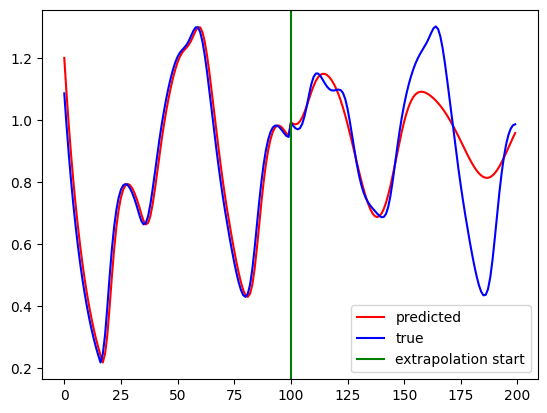

In [29]:
# plot validation set
# combine 100 last samples from training set with extrapolation results
predicted = np.hstack(
    [X.view(-1).detach().numpy()[:100], res.view(-1).detach().numpy()]
)
true = np.hstack([y.view(-1).detach().numpy()[:100], y_test.view(-1).detach().numpy()])


plt.plot(range(2 * extrapolation_steps), predicted, "r", label="predicted")
plt.plot(range(2 * extrapolation_steps), true, "b", label="true")
plt.axvline(x=100, color="g", label="extrapolation start")
plt.legend()
plt.show()

# Ekstraploacja Szeregu czasowego modelu Handy za pomocą ESN

## Generowanie Szeregu Czasowego dla 10000 kroków

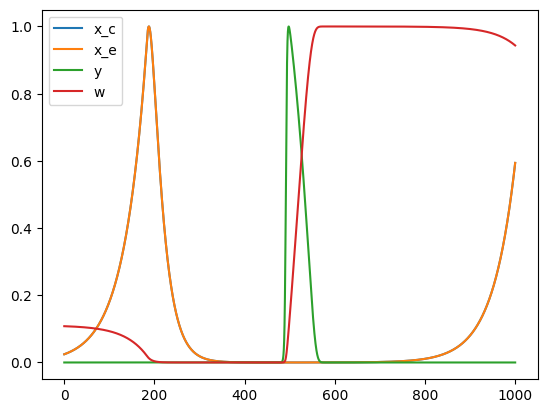

In [3]:
# Poniższe funkcje pochodzą z repozytorium z kodem modelu Handy używanym w ramach tego przedmiotu
import json
import sys

sys.path.insert(0, "..")
from handy.handy_prototype import (
    simulate_handy,
)
from utils import pack_parameters, pack_variables, plot_handy, plot_handy_partial

with open("../config/baseline_config.json", "r") as config_fd:
    config_json = json.load(config_fd)

parameters = pack_parameters(config_json["parameters"])
initial_value = pack_variables(config_json["initial_value"])
differential_t = float(config_json["differential_t"])
simulation_steps = config_json["simulation_steps"]

simulation = simulate_handy(initial_value, parameters, differential_t, simulation_steps)
plot_handy(simulation, min(simulation_steps, len(simulation)), differential_t)

## Prepare training and testing dataset.

In [4]:
def prepare_training_data(simulation, window_start, window_end, train_fraction):
    data = simulation[window_start:window_end]

    split_idx = int((window_end - window_start) * train_fraction)
    train = data[:split_idx]
    test = data[split_idx:]

    X_train = train[0 : len(train) - 1, :]
    y_train = train[1 : len(train), :]

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    initial_extrapolation_state = train[-1:, :]

    return X_train, y_train, test, initial_extrapolation_state


def prepare_transformations(simulation):
    MIN_ARR = np.min(simulation, axis=0)
    MAX_ARR = np.max(simulation, axis=0)
    return (
        lambda x: (x - MIN_ARR) / (MAX_ARR - MIN_ARR),
        lambda x: x * (MAX_ARR - MIN_ARR) + MIN_ARR,
    )


def evaluate_model(model, extrapolation_steps, state):
    result = []
    for _ in range(extrapolation_steps):
        state = model(state)
        result.append(state)
    return torch.vstack(result).detach().numpy()


transform, inverse_transform = prepare_transformations(simulation)
X_train, y_train, test, initial_extrapolation_state = prepare_training_data(
    simulation, 4500, 5500, 0.9
)

## ESN model definition and training

In [10]:
model = GroupedDeepESN(
    groups=3,
    input_size=4,
    num_layers=(3, 3, 3),
    hidden_size=500,
)

model.fit(
    torch.from_numpy(transform(X_train)),
    torch.from_numpy(transform(y_train)),
)

## Extrapolation

Original Testing Data


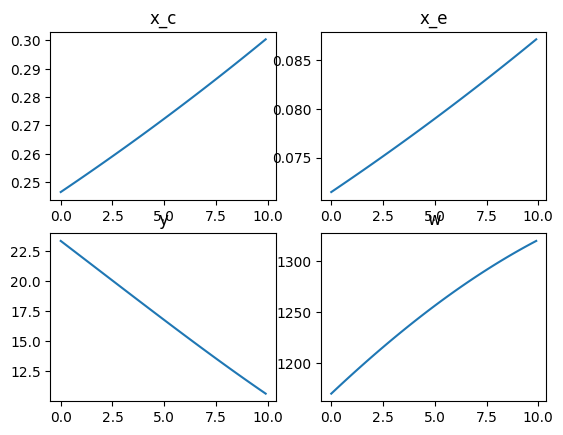

Extrapolated Data


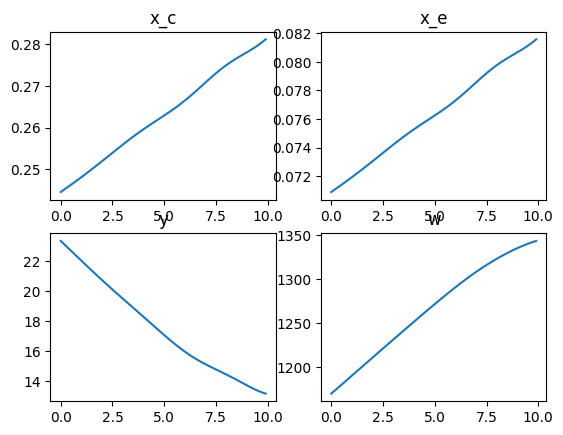

In [11]:
extrapolation = evaluate_model(
    model, len(test), torch.from_numpy(transform(initial_extrapolation_state))
)

print("Original Testing Data")
plot_handy_partial(test, len(test), differential_t)

print("Extrapolated Data")
plot_handy_partial(
    inverse_transform(extrapolation),
    len(extrapolation),
    differential_t,
)